In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_csv('results.csv')

df['model'] = df['model'].replace({'PaLM': 'PaLM 2', 
                                   'Claude 2': 'Claude 2',
                                   'Claude Instant': 'Claude Instant 1.2',
                                   'GPT 3.5 Turbo': 'GPT 3.5 Turbo',
                                   'GPT 4 Turbo': 'GPT 4 Turbo',
                                   'Mistral': 'Mistral-7b',
                                   'Mpt': 'MPT-30b',
                                   'Phi': 'Phi-1.5',
                                   'Vicuna': 'Vicuna-13b',
                                   'Yi': 'Yi-34b'})

df['complexity'] = df['complexity'].replace({
                                    'np-cmp': 'NP-Complete', 
                                    'p': 'P',
                                    'np-hard': 'NP-Hard'
                                    })

df['problem'] = df['problem'].str.replace(r'_?Results', '', regex=True)
df['problem'] = df['problem'].replace({'bsp': 'sas'})
df['problem'] = df['problem'].str.upper()
problem_order = ['SAS', 'EDP', 'SPP', 'GCP_D', 'TSP_D', 'KSP', 'GCP', 'TSP', 'MSP']
df['problem'] = pd.Categorical(df['problem'], categories=problem_order, ordered=True)

level_order = ['Lvl 1', 'Lvl 2', 'Lvl 3', 'Lvl 4', 'Lvl 5', 'Lvl 6', 'Lvl 7', 'Lvl 8', 'Lvl 9', 'Lvl 10']
df['level'] = pd.Categorical(df['level'], categories=level_order, ordered=True)

df = df.sort_values(by=['model', 'level', 'problem'])
df.head(10)

,model,problem,level,Average accuracy,Failure,weighted_accuracy,weighted_failed,complexity,lvl_correctness,is_close
460,Claude 2,SAS,Lvl 1,0.8,0.2,0.014545,0.02,P,"[True, True, True, True, True, True, True, 'fa...",True
190,Claude 2,EDP,Lvl 1,0.5,0.0,0.009091,0.00,P,"[False, True, True, False, False, False, True,...",True
320,Claude 2,SPP,Lvl 1,0.3,0.0,0.005455,0.00,P,"[False, True, False, True, True, False, False,...",True
390,Claude 2,GCP_D,Lvl 1,0.9,0.0,0.016364,0.00,NP-Complete,"[True, True, True, True, True, False, True, Tr...",True
360,Claude 2,TSP_D,Lvl 1,0.9,0.1,0.016364,0.01,NP-Complete,"[True, True, True, True, True, 'failed', True,...",True
730,Claude 2,KSP,Lvl 1,0.1,0.1,0.001818,0.01,NP-Complete,"[True, False, False, False, 'failed', False, F...",True
860,Claude 2,GCP,Lvl 1,0.0,0.1,0.000000,0.01,NP-Hard,"[False, False, False, False, False, False, Fal...",True
600,Claude 2,TSP,Lvl 1,0.6,0.0,0.010909,0.00,NP-Hard,"[True, False, False, False, True, False, True,...",True
120,Claude 2,MSP,Lvl 1,0.0,0.1,0.000000,0.01,NP-Hard,"[False, False, False, False, False, False, Fal...",True
461,Claude 2,SAS,Lvl 2,0.9,0.0,0.032727,0.00,P,"[True, True, True, True, False, True, True, Tr...",True


In [3]:
set(df['model'].to_list())

{'Claude 2',
 'Claude Instant 1.2',
 'GPT 3.5 Turbo',
 'GPT 4 Turbo',
 'MPT-30b',
 'Mistral-7b',
 'PaLM 2',
 'Phi-1.5',
 'Phi-2',
 'Qwen-14b',
 'Vicuna-13b',
 'Yi-34b'}

In [4]:
model_df = df.groupby(['model', 'complexity', 'problem'])['Average accuracy'].agg(list).reset_index()
model_df = model_df.dropna(subset=['Average accuracy'])
model_df

,model,complexity,problem,Average accuracy
3,Claude 2,NP-Complete,GCP_D,"[0.9, 0.9, 0.8, 0.8, 0.7, 0.6, 0.4, 0.6, 0.3, ..."
4,Claude 2,NP-Complete,TSP_D,"[0.9, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.9, 1.0, ..."
5,Claude 2,NP-Complete,KSP,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,Claude 2,NP-Hard,GCP,"[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ..."
16,Claude 2,NP-Hard,TSP,"[0.6, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
313,Yi-34b,NP-Hard,TSP,"[0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
314,Yi-34b,NP-Hard,MSP,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
315,Yi-34b,P,SAS,"[0.8, 0.9, 0.8, 0.8, 0.5, 0.5, 0.6, 0.5, 0.8, ..."
316,Yi-34b,P,EDP,"[0.6, 0.4, 0.2, 0.1, 0.1, 0.0, 0.0, 0.3, 0.2, ..."


In [29]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['font.family'] = 'Arial'
#rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 11
rcParams['axes.titlesize'] = 11
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['figure.titlesize'] = 11

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

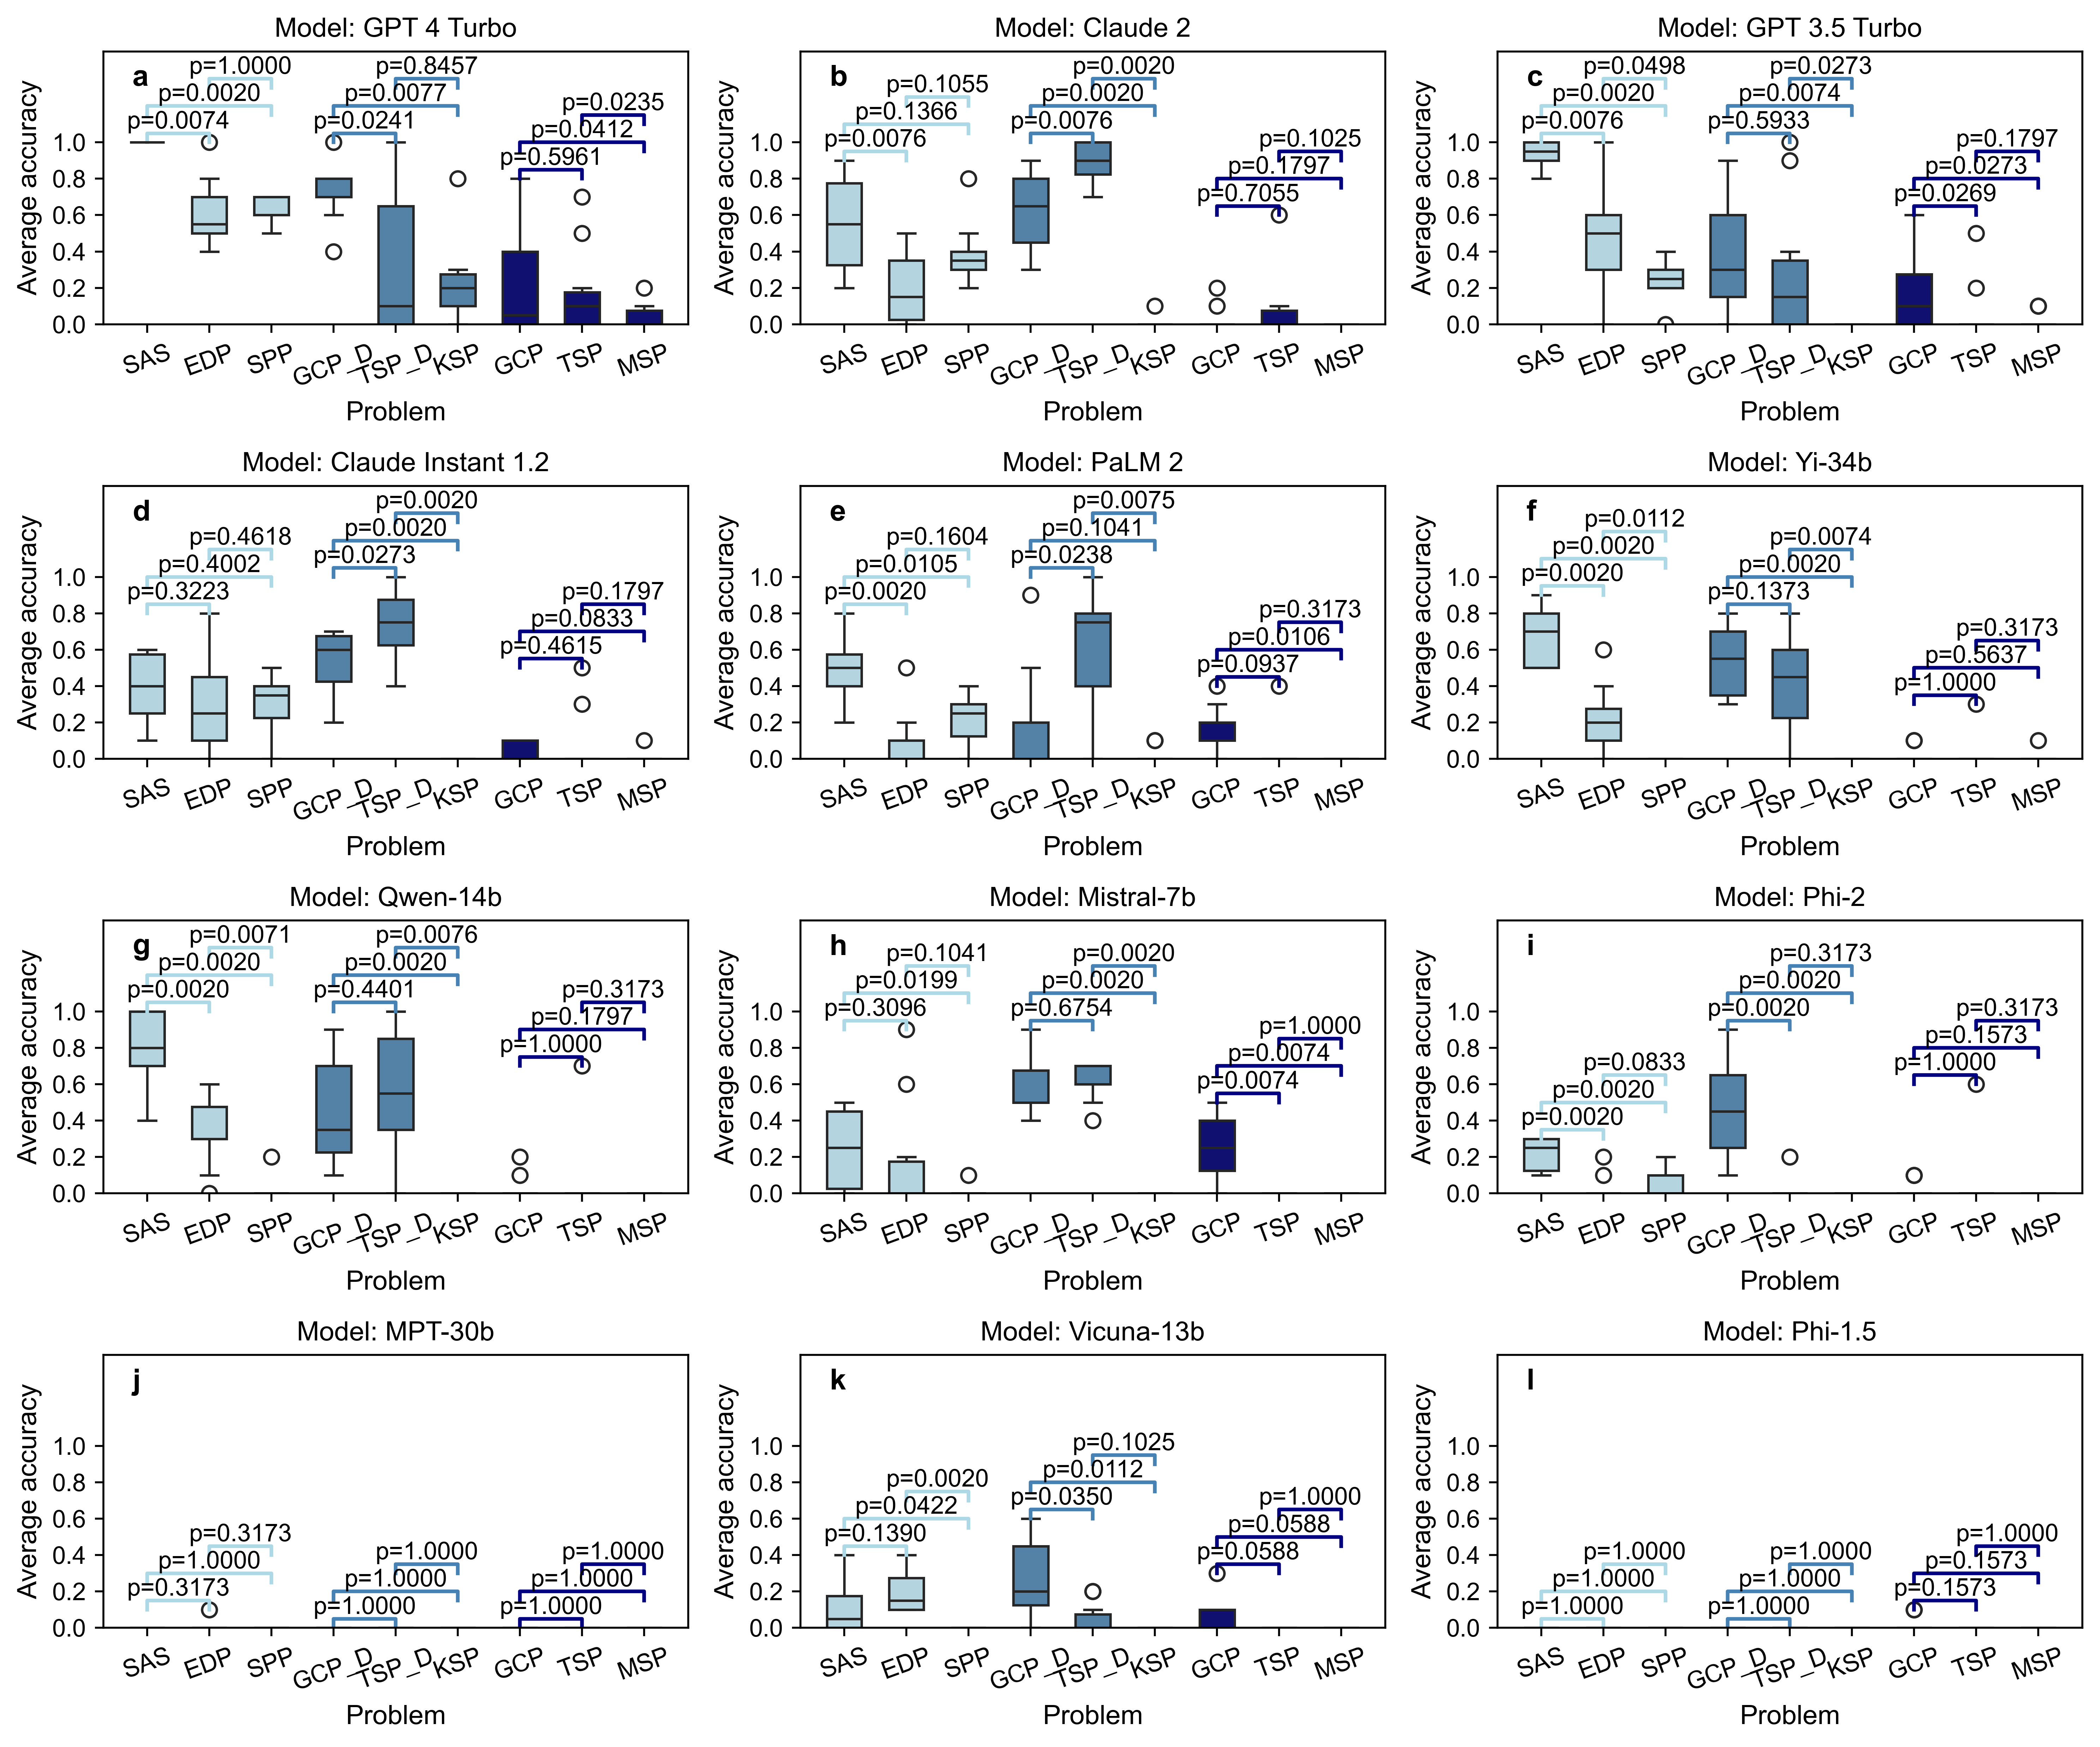

In [30]:
import itertools
from scipy.stats import wilcoxon

colors = {'P': 'lightblue', 'NP-Complete': 'steelblue', 'NP-Hard': 'navy'}
complexities = ['P', 'NP-Complete', 'NP-Hard']

def wilcoxon_test(complexity_df, problem_pairs):
    # Perform Wilcoxon test for each pair
    p_values = []
    for pair in problem_pairs:
        problem1 = pair[0]
        problem2 = pair[1]
        pair_df = complexity_df[(complexity_df['problem'] == problem1) | (complexity_df['problem'] == problem2)]
        x = pair_df[pair_df['problem'] == problem1]['Average accuracy']
        y = pair_df[pair_df['problem'] == problem2]['Average accuracy']
        try:
            stat, p_value = wilcoxon(x, y)
        except:
            p_value = 1.0
        p_values.append(p_value)
    return p_values


def annotate_statistics(complexity_df, complexity, problem_pairs, p_values, ax):
    # Annotate the boxplot with the p-values
    offset = 0
    for i, pair in enumerate(problem_pairs):
        problem1 = pair[0]
        problem2 = pair[1]
        x1 = complexity_df[complexity_df['problem'] == problem1]['problem'].index[0]
        x2 = complexity_df[complexity_df['problem'] == problem2]['problem'].index[0]
        y = complexity_df['Average accuracy'].max() + offset
        h = 0.05
        col = colors[complexity]
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text((x1+x2)*.5, y+h, f"p={p_values[i]:.4f}", ha='center', va='bottom') # add "color=col" to this line to set p-value color
        offset += 0.15


def create_figure(model_df, model, ax):
    # Create a figure for the model
    mdf = model_df[model_df['model']==model]
    mdf = mdf.sort_values(by=['complexity'], key=lambda x: x.map({'P': 0, 'NP-Complete': 1, 'NP-Hard': 2}))
    mdf = mdf.reset_index()
    mdf = mdf.explode('Average accuracy')
    for complexity in complexities:
        complexity_df = mdf[mdf['complexity'] == complexity]
        problems = complexity_df['problem'].unique()
        problem_pairs = list(itertools.combinations(problems, 2))
        p_values = wilcoxon_test(complexity_df, problem_pairs)
        sns.boxplot(x='problem', y='Average accuracy', hue='complexity', data=complexity_df, gap=.3, palette=colors, ax=ax)
        annotate_statistics(complexity_df, complexity, problem_pairs, p_values, ax)
    
    ax.legend().remove()
    ax.set_title(f"Model: {model}")
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlabel('Problem')
    ax.set_ylim(0, 1.5)

models = df['model'].unique()
order = ['GPT 4 Turbo', 'Claude 2', 'GPT 3.5 Turbo', 'Claude Instant 1.2', 'PaLM 2', 'Yi-34b', 
         'Qwen-14b', 'Mistral-7b', 'Phi-2', 'MPT-30b', 'Vicuna-13b', 'Phi-1.5']
sorted_models = sorted(models, key=lambda x: order.index(x))

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

for i, model in enumerate(sorted_models):
    row = i // 3  # Calculate the row index
    col = i % 3 
    create_figure(model_df, model, axs[row, col])
    
    axs[row, col].text(0.05, 0.95, labels[i], transform=axs[row, col].transAxes,
                       fontsize=12, fontweight='bold', va='top', ha='left')
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()
